In [2]:
import autokeras as ak

ModuleNotFoundError: No module named 'autokeras'

In [49]:
import sys, os, decimal, json
sys.path.append(os.path.realpath('..'))
import json, time
import pandas as pd
import random
import matplotlib.pyplot as plt
import glob

import matplotlib.pyplot as plt
import numpy as np
import PIL, json
import tensorflow as tf
import socket
import pathlib
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageOps

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.applications import VGG16

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from TrainingPipelines.ImageClassifier.ModelBuilder import build_and_train

import seaborn as sns
import mplcyberpunk
tf.random.set_seed(42)

plt.style.use("cyberpunk")
plt.rcParams['figure.facecolor'] = '#0d1117'
plt.rcParams['axes.facecolor'] = '#0d1117'
plt.rcParams['savefig.facecolor'] = '#0d1117'

In [50]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [51]:
reduction = 1

img_width = int(40/reduction)
img_height = int(600/reduction)

In [52]:
image_names = []
path = pathlib.Path(r'O:\eve_models\training_data\route_y')
for data in glob.glob(f"{path}\*.png"):
    file = data.split('\\')[-1:][0]
    image_names.append(file)

In [53]:
random.shuffle(image_names)

In [54]:
image_data = {}
f = open(f"{path}\\boxes.json")
image_data_raw = json.load(f)
f.close()

for data in image_data_raw:
    image_data[data['image_name']] = data['bbox'][1:2]
image_data[list(image_data.keys())[0]]

[377]

In [55]:
def convert_to_baw(img, thresh=80):
    fn = lambda x: 255 if x > thresh else 0
    return img.convert('L').point(fn, mode='1')

In [56]:
train_names, val_names, test_names = np.split(image_names, [int(len(image_names)*0.7), int(len(image_names)*0.9)])

In [57]:
train_x = []
for image_name in tqdm(train_names):
    try:
        img = Image.open(f"{path}\\{image_name}")
        #img = convert_to_baw(img)
        img = img.crop((120, 0, 160, 600))
        if reduction != 1:
            img = img.resize((img_width, img_height), resample=Image.Resampling.NEAREST)
        train_x.append(np.array(img))
    except:
        print(f"{path}\\{image_name}")
    
val_x = []
for image_name in tqdm(val_names):
    img = Image.open(f"{path}\\{image_name}")
    #img = convert_to_baw(img)
    img = img.crop((120, 0, 160, 600))
    if reduction != 1:
        img = img.resize((img_width, img_height), resample=Image.Resampling.NEAREST)
    val_x.append(np.array(img))
    
test_x = []
for image_name in tqdm(test_names):
    img = Image.open(f"{path}\\{image_name}")
    #img = convert_to_baw(img)
    img = img.crop((120, 0, 160, 600))
    if reduction != 1:
        img = img.resize((img_width, img_height), resample=Image.Resampling.NEAREST)
    test_x.append(np.array(img))

100%|███████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 237.22it/s]


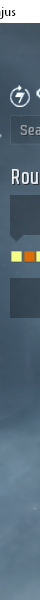

In [58]:
Image.fromarray(train_x[1000])

In [59]:
len(train_x)

1218

In [60]:
train_x[0].shape

(600, 40, 3)

In [61]:
train_y = []
for image_name in tqdm(train_names):
    train_y.append(image_data[image_name][0])
    
val_y = []
for image_name in tqdm(val_names):
    val_y.append(image_data[image_name][0])
    
test_y = []
for image_name in tqdm(test_names):
    test_y.append(image_data[image_name][0])

100%|████████████████████████████████████████████████████████████████████████████| 175/175 [00:00<00:00, 174845.93it/s]


In [62]:
len(train_x)

1218

In [63]:
train_x[0].shape

(600, 40, 3)

In [64]:
len(train_y)

1218

In [65]:
train_y[0]

256

In [66]:
augmentations = 20
aug_range_y = [-60, 80]

#balance_names = []

train_alter_x = []
train_alter_y = []
train_alter_names = []
for i in tqdm(range(len(train_x))):
    true_aug = augmentations
    if train_names[i] in balance_names:
        true_aug = augmentations * (balance_names.count(train_names[i]))
        
    for a in range(true_aug):
        img = Image.fromarray(train_x[i])
        x_pixels = 0  
        y_pixels = random.randint(*aug_range_y)
        translated_img = img.transform(img.size, Image.AFFINE, (1, 0, x_pixels, 0, 1, y_pixels))
        train_alter_x.append(np.array(translated_img))

        train_alter_y.append(train_y[i] - y_pixels)
        train_alter_names.append(train_names[i])

train_x = train_x + train_alter_x
train_y = train_y + train_alter_y
train_names = np.array(list(train_names) + train_alter_names)

  6%|████▌                                                                           | 70/1218 [00:48<13:08,  1.46it/s]

KeyboardInterrupt



In [ ]:
train_y[0]

In [ ]:
train_y[-1]

In [ ]:
len(train_x)

In [ ]:
train_x[0].shape

In [ ]:
len(train_y)

In [ ]:
len(train_alter_y)

In [ ]:
train_x = np.array(train_x)
val_x = np.array(val_x)
test_x = np.array(test_x)

train_y = np.array(train_y) / np.array([1000])
val_y = np.array(val_y) / np.array([1000])
test_y = np.array(test_y) / np.array([1000])